# Yet antoher re-implementation and cross-check for absorption on disk
In this notebook I will implement the formulas for the $\gamma \gamma$ absorption on disk presented in Finke 2016 and Dermer 2009 and comapre them.

In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import m_e, c, G, M_sun
import matplotlib.pyplot as plt
import pkg_resources
from IPython.display import Image
import sys
sys.path.append("../../")
from agnpy.targets import SSDisk
from agnpy.absorption import sigma
from agnpy.utils.math import axes_reshaper
from agnpy.utils.conversion import nu_to_epsilon_prime, to_R_g_units

In [2]:
# useful constants
# electron radius
r_e = 2.81794 * 1e-15 * u.cm

## Formula derived from [Finke 2016](https://iopscience.iop.org/article/10.3847/0004-637X/830/2/94/pdf)
Let us consider the general formula for absorption

\begin{equation}
\tau_{\gamma \gamma}(\hat{\nu}_1) = 
    \int_{r}^{\infty} {\rm d}l \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{-1}^{1}  {\rm d}\mu \, (1 - \cos\psi) \,
    \int_{0}^{\infty} {\rm d}\epsilon \, 
    \frac{\underline{u}(\epsilon, \Omega; l)}{\epsilon m_{\rm e} c^2} \, 
    \sigma_{\gamma \gamma}(s),
\end{equation}

where, for the Skakura Sunyaev Disk

\begin{equation}
    \underline{u}(\epsilon, \Omega; r) = \frac{3 G M \dot{m}}{(4 \pi)^2 c R^3}\varphi(R) \, \delta(\epsilon - \epsilon_0(R))
\end{equation}

replacing, and simplifying

\begin{equation}
\begin{split}
\tau_{\gamma \gamma}(\hat{\nu}_1) &= 
    \int_{r}^{\infty} {\rm d}l \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{\mu_{\rm min}}^{\mu_{\rm max}}  {\rm d}\mu \, (1 - \cos\psi) \,
    \int_{0}^{\infty} {\rm d}\epsilon \, 
    \frac{3 G M \dot{m}}{(4 \pi)^2 c R^3}\varphi(R) \, \delta(\epsilon - \epsilon_0(R))
    \frac{1}{\epsilon m_{\rm e} c^2} \sigma_{\gamma \gamma}(s) \\
    &= \frac{3 G M \dot{m}}{(4 \pi)^2 m_{\rm e} c^3}
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{\mu_{\rm min}}^{\mu_{\rm max}}  {\rm d}\mu \, (1 - \cos\psi) \,
    \frac{1}{R^3}\frac{\varphi(R)}{\epsilon(R)} \sigma_{\gamma \gamma}(s).
\end{split}
\end{equation}

The extremes of integration in cosine $(\mu_{\rm in}, \mu_{\rm out})$ will change depending on the distance $l$, so let us change to an integration in $R$: $\mu = \frac{1}{\sqrt{1 + \frac{R^2}{r^2}}} \Rightarrow \frac{{\rm d}\mu}{{\rm d}R} = - \frac{1}{2}\frac{1}{\left(1 + \frac{R^2}{r^2}\right)^{3/2}}\frac{2R}{r^2} = - \frac{1}{\mu^3}\frac{R}{r^2}$.

\begin{equation}
\begin{split}
\tau_{\gamma \gamma}(\hat{\nu}_1) &= 
    \frac{3 G M \dot{m}}{(4 \pi)^2 m_{\rm e} c^3}
    \int_{r}^{\infty} {\rm d}l \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{R_{\rm out}}^{R_{\rm in}} -\frac{1}{\mu^3}\frac{R}{l^2}{\rm d}R \,
    (1 - \cos\psi) \, \frac{1}{R^3}\frac{\varphi(R)}{\epsilon(R)} \sigma_{\gamma \gamma}(s) \\
    &= \frac{3 G M \dot{m}}{(4 \pi)^2 m_{\rm e} c^3}
    \int_{r}^{\infty} {\rm d}l \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{R_{\rm in}}^{R_{\rm out}}{\rm d}R \,
    (1 - \cos\psi) \, \frac{1}{\mu^3}\frac{1}{l^2}\frac{1}{R^2} 
    \frac{\varphi(R)}{\epsilon(R)} \sigma_{\gamma \gamma}(s) \\
    &= \frac{3 G M \dot{m}}{(4 \pi)^2 m_{\rm e} c^3 R_g^2}
    \int_{r}^{\infty} \frac{{\rm d}l}{R_g} \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{R_{\rm in}}^{R_{\rm out}} \frac{{\rm d}R}{R_g} \,
    (1 - \cos\psi) \, \frac{1}{\mu^3}\frac{R_g^2}{l^2}\frac{R_g^2}{R^2} 
    \frac{\varphi(R)}{\epsilon(R)} \sigma_{\gamma \gamma}(s) \\
    &= \frac{3 \dot{m}}{(4 \pi)^2 m_{\rm e} c R_g}
    \int_{\tilde{r}}^{\infty} {\rm d}\tilde{l} \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{\tilde{R}_{\rm in}}^{\tilde{R}_{\rm out}} {\rm d}\tilde{R} \,
    (1 - \cos\psi) \, \frac{1}{\mu^3}\frac{1}{\tilde{l}^2}\frac{1}{\tilde{R}^2} 
    \frac{\varphi(\tilde{R})}{\epsilon(\tilde{R})} \sigma_{\gamma \gamma}(s) \\
    &= \frac{3 L_{\rm disk}}{(4 \pi)^2 \eta m_{\rm e} c^3 R_g}
    \int_{\tilde{r}}^{\infty} {\rm d}\tilde{l} \,
    \int_{0}^{2\pi} {\rm d}\phi \, 
    \int_{\tilde{R}_{\rm in}}^{\tilde{R}_{\rm out}} {\rm d}\tilde{R} \,
    (1 - \cos\psi) \, \frac{1}{\mu^3}\frac{1}{\tilde{l}^2}\frac{1}{\tilde{R}^2} 
    \frac{\varphi(\tilde{R})}{\epsilon(\tilde{R})} \sigma_{\gamma \gamma}(s),
\end{split}
\end{equation}

and we have used $R_g=GM/c^2$ and $L_{\rm disk} = \eta \dot{m} c^2$.

Assuming $\mu_s=1 \Rightarrow \cos\psi=\mu$ and
\begin{equation}
\tau_{\gamma \gamma}(\hat{\nu}_1) = \frac{3 L_{\rm disk}}{8 \pi^2 \eta m_{\rm e} c^3 R_g}
    \int_{\tilde{r}}^{\infty} {\rm d}\tilde{l} \,
    \int_{\tilde{R}_{\rm in}}^{\tilde{R}_{\rm out}} {\rm d}\tilde{R} \,
    \frac{(1 - \mu)}{\mu^3} \frac{1}{\tilde{l}^2 \tilde{R}^2} 
    \frac{\varphi(\tilde{R})}{\epsilon(\tilde{R})} \sigma_{\gamma \gamma}(s).
\end{equation}

In [3]:
def evaluate_tau_disk_finke_2016(        
    nu,
    z,
    M_BH,
    L_disk,
    eta,
    R_in,
    R_out,
    r,
    R_tilde_size=100,
    l_tilde_size=50,
):
    """expression of the disk absorption derived from the formulas in Finke 2016"""
    # conversions
    R_g = (G * M_BH / c ** 2).to("cm")
    r_tilde = to_R_g_units(r, M_BH)
    R_in_tilde = to_R_g_units(R_in, M_BH)
    R_out_tilde = to_R_g_units(R_out, M_BH)   
    # multidimensional integration
    R_tilde = np.linspace(R_in_tilde, R_out_tilde, R_tilde_size)
    l_tilde = np.logspace(0, 6, l_tilde_size) * r_tilde
    epsilon_1 = nu_to_epsilon_prime(nu, z)
    _R_tilde, _l_tilde, _epsilon_1 = axes_reshaper(R_tilde, l_tilde, epsilon_1)
    _epsilon = SSDisk.evaluate_epsilon(L_disk, M_BH, eta, _R_tilde)
    _phi_disk = 1 - (R_in_tilde / _R_tilde) ** (1 / 2)
    _mu = (1 + _R_tilde ** 2 / _l_tilde ** 2) ** (-1 / 2)
    s = _epsilon * _epsilon_1 * (1 - _mu) / 2
    integrand = (
        (1 - _mu)
        / _mu ** 3
        / _l_tilde ** 2
        / _R_tilde ** 2
        * _phi_disk
        / _epsilon
        * sigma(s)
    )
    integral_R_tilde = np.trapz(integrand, R_tilde, axis=0)
    integral = np.trapz(integral_R_tilde, l_tilde, axis=0)
    prefactor = 3 * L_disk / (8 * np.pi**2 * eta * m_e * c**3 * R_g)
    return (prefactor * integral).to_value("")

In [4]:
# disk parameters as in Finke 2016
M_BH = 1.2 * 1e9 * M_sun.cgs
L_disk = 2 * 1e46 * u.Unit("erg s-1")
R_g = (G * M_BH / c**2).to("cm")
eta = 1 / 12
R_in = 6 * R_g
R_out = 200 * R_g

disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
print(disk)

# parameters of 3C454.3 
z = 0.859
R_line = 1.1 * 1e17 * u.cm
# distance of the disk
r = 0.1 * R_line

* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 2.39e+42 g
 - L_disk (disk luminosity): 2.00e+46 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 2.67e+26 g / s
 - R_in (disk inner radius): 1.06e+15 cm
 - R_out (disk inner radius): 3.54e+16 cm


/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


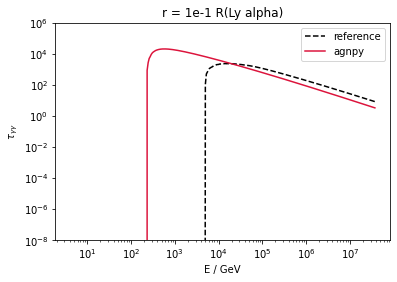

/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


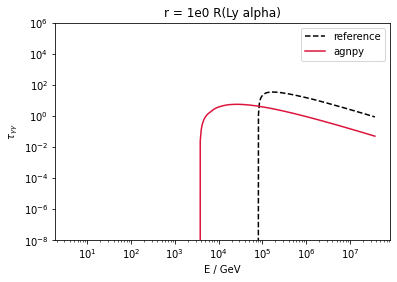

/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


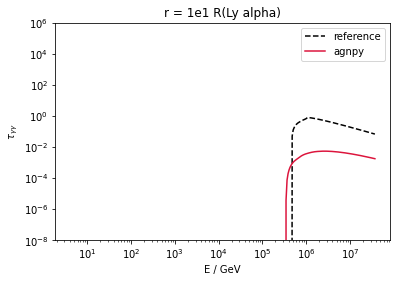

/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


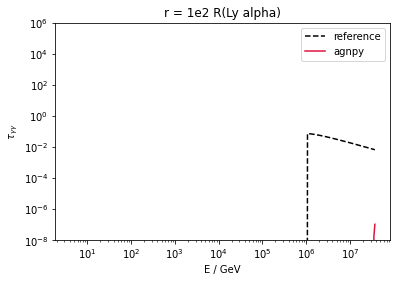

In [5]:
# let us try to reproduce the data shared by Finke
for l in ["1e-1", "1e0", "1e1", "1e2"]:
    # read the reference SED in Figure 14 of Finke 2016
    data_file_ref_abs = f"../../agnpy/data/reference_taus/finke_2016/figure_14_left/tau_SSdisk_r_{l}_R_Ly_alpha.txt"
    data_ref = np.loadtxt(data_file_ref_abs, delimiter=",")
    # read energies and opacity values
    E_ref = data_ref[:, 0] * u.GeV
    tau_ref = data_ref[:, 1]
    nu_ref = E_ref.to("Hz", equivalencies=u.spectral())
    # compute the tau
    _r = float(l) * R_line
    tau = evaluate_tau_disk_finke_2016(nu_ref, z, M_BH, L_disk, eta, R_in, R_out, _r)
    # plot it against the reference
    plt.loglog(E_ref, tau_ref, ls="--", color="k", label="reference")
    plt.loglog(E_ref, tau, ls="-", color="crimson", label="agnpy")
    plt.ylim([1e-8, 1e6])
    plt.title(f"r = {l} R(Ly alpha)")
    plt.ylabel(r"$\tau_{\gamma\gamma}$")
    plt.xlabel("E / GeV")
    plt.legend()
    plt.show()

## Formula from [Dermer et al. 2009](https://iopscience.iop.org/article/10.1088/0004-637X/692/1/32/pdf), Eq. 80
Let us directly take Eq. (80) in Dermer et al. 2009 reporting the same quantity (again we are assuming $\mu_s = 1$).
\begin{equation}
\tau_{\gamma \gamma}(\hat{\nu}_1) = 3 \times 10^6 \frac{l_{\rm Edd}^{3/4} M_8^{1/4}}{\eta^{3/4}}
    \int_{\tilde{r}}^{\infty} \frac{{\rm d}\tilde{l}}{\tilde{l}^2} \,
    \int_{\tilde{R}_{\rm in}}^{\tilde{R}_{\rm out}} \frac{{\rm d}\tilde{R}}{\tilde{R}^{5/4}} \,
    \frac{\left[\varphi(\tilde{R})\right]^{1/4}}{\left(1 + \frac{\tilde{R}^2}{\tilde{l}^2}\right)^{3/2}}
    \left[\frac{\sigma_{\gamma \gamma}(s)}{\pi r_e^2}\right] (1 - \mu).
\end{equation}

As the author notice:
$$ \frac{\tau_{\gamma \gamma}}{M_8} = \text{function of } \xi \text{ and } r$$

where $\xi = \left(\frac{l_{\rm Edd}}{\eta M_8}\right)^{1/4}$.

Reorganising the formula:

\begin{equation}
\tau_{\gamma \gamma}(\hat{\nu}_1) = 3 \times 10^6 M_8 \xi^3
    \int_{\tilde{r}}^{\infty} \frac{{\rm d}\tilde{l}}{\tilde{l}^2} \,
    \int_{\tilde{R}_{\rm in}}^{\tilde{R}_{\rm out}} \frac{{\rm d}\tilde{R}}{\tilde{R}^{5/4}} \,
    \frac{\left[\varphi(\tilde{R})\right]^{1/4}}{\left(1 + \frac{\tilde{R}^2}{\tilde{l}^2}\right)^{3/2}}
    \left[\frac{\sigma_{\gamma \gamma}(s)}{\pi r_e^2}\right] (1 - \mu).
\end{equation}

In [6]:
def evaluate_tau_dermer_2009(        
    E,
    z,
    M_8,
    csi,
    R_in_tilde,
    R_out_tilde,
    r_tilde,
    R_tilde_size=100,
    l_tilde_size=50,
):
    """expression of the disk absorption copied from Dermer 2009"""
    R_tilde = np.linspace(R_in_tilde, R_out_tilde, R_tilde_size)
    l_tilde = np.logspace(0, 6, l_tilde_size) * r_tilde
    epsilon_1 = (E / (m_e * c**2)).to_value("") * (1 + z) 
    _R_tilde, _l_tilde, _epsilon_1 = axes_reshaper(R_tilde, l_tilde, epsilon_1)
    _epsilon = 2.7 * 1e-4 * csi * _R_tilde ** (-3 / 4)
    _phi_disk = 1 - (R_in_tilde / _R_tilde) ** (1 / 2)
    _mu = 1 / (1 + _R_tilde ** 2 / _l_tilde ** 2) ** (1 / 2)
    _s = _epsilon_1 * _epsilon * (1 - _mu) / 2
    integrand = (
        1
        / _l_tilde ** 2
        / _R_tilde ** (5 / 4)
        / (1 + _R_tilde ** 2 / _l_tilde ** 2) ** (3 / 2)
        * _phi_disk ** (1 / 4)
        * (sigma(_s) / (np.pi * r_e ** 2)).to_value("")
        * (1 - _mu)
    )
    integral_R_tilde = np.trapz(integrand, R_tilde, axis=0)
    integral = np.trapz(integral_R_tilde, l_tilde, axis=0)
    prefactor = 3 * 1e6 * M_8 * csi ** 3
    return prefactor * integral

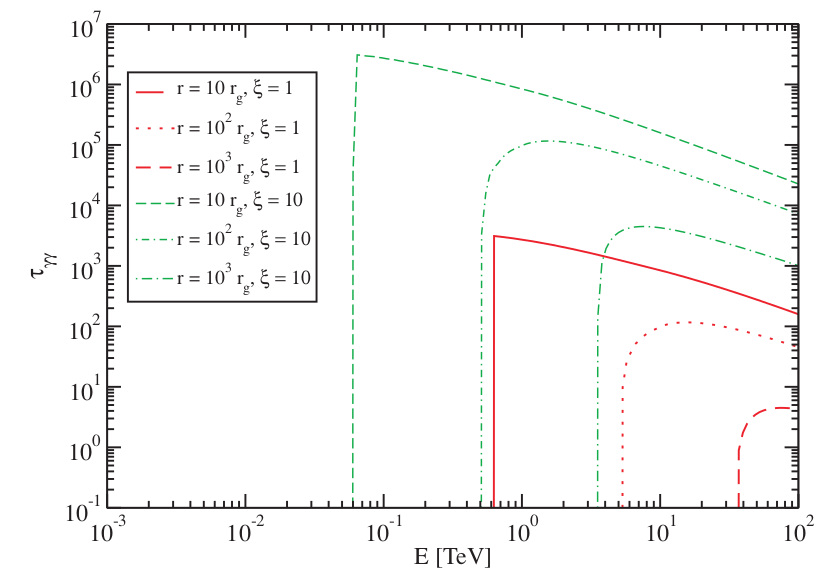

In [7]:
# let us try to reproduce Figure 7 in Dermer et al 2009
Image("figures/figure_7_dermer_et_al_2009.png", width = 600, height = 400)

/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: invalid value encountered in sqrt
  beta_cm = np.sqrt(1 - 1 / s)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: invalid value encountered in sqrt
  beta_cm = np.sqrt(1 - 1 / s)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: divide by zero encountered in true_divide
  beta_cm = np.sqrt(1 - 1 / s)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: invalid value encountered in sqrt
  beta_cm = np.sqrt(1 - 1 / s)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: invalid value encountered in sqrt
  beta_cm = np.sqrt(1 - 1 / s)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarn

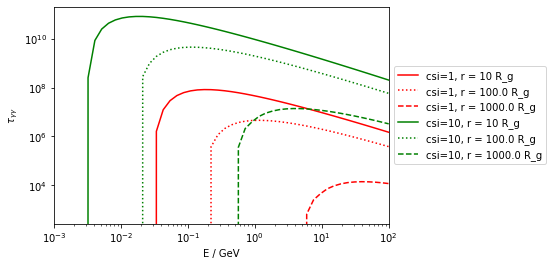

In [8]:
z = 1
M_8 = 1
csi = [1, 10]
r_tilde = [10, 1e2, 1e3] 

E = np.logspace(-3, 2, 50) * u.TeV

for color, _csi in zip(["red", "green"], csi):
    for ls, _r_tilde in zip(["-", ":", "--"], r_tilde):
        tau = evaluate_tau_dermer_2009(E, z=z, M_8=M_8, csi=_csi, R_in_tilde=6, R_out_tilde=200, r_tilde=_r_tilde)
        plt.loglog(E, tau, color=color, ls=ls, label=f"csi={_csi}, r = {_r_tilde} R_g")
plt.xlim([1e-3, 1e2])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$\tau_{\gamma\gamma}$")
plt.xlabel("E / GeV")
plt.show()

## Check Finke 2016 vs Dermer 2009
Let us check the two formulas implementations against each other.
Let us use the same parameters of the accretion disk we defined above.

In [9]:
print(f"distance from BH: {r:.2e}")
print("accretion disk considered:")
print(disk)

distance from BH: 1.10e+16 cm
accretion disk considered:
* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 2.39e+42 g
 - L_disk (disk luminosity): 2.00e+46 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 2.67e+26 g / s
 - R_in (disk inner radius): 1.06e+15 cm
 - R_out (disk inner radius): 3.54e+16 cm


/home/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/lib/python3.8/site-packages/agnpy/absorption/absorption.py:35: RuntimeWarning: invalid value encountered in sqrt
  beta_cm = np.sqrt(1 - 1 / s)


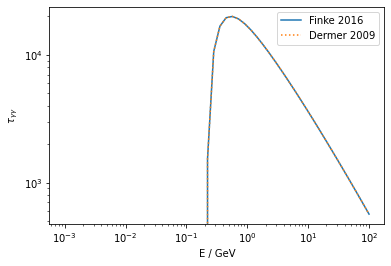

In [10]:
nu = E.to("Hz", equivalencies = u.spectral())
tau_finke = evaluate_tau_disk_finke_2016(nu, z, disk.M_BH, disk.L_disk, disk.eta, disk.R_in, disk.R_out, r)
# calculate csi to use Dermer's formula
csi = (disk.l_Edd / (disk.M_8 * disk.eta))**(1/4)
r_tilde = (r / disk.R_g).to_value("")
tau_dermer = evaluate_tau_dermer_2009(E, z, disk.M_8, csi, disk.R_in_tilde, disk.R_in_tilde, r_tilde)

plt.loglog(E, tau_finke, label="Finke 2016")
plt.loglog(E, tau_finke, label="Dermer 2009", ls=":")
plt.ylabel(r"$\tau_{\gamma\gamma}$")
plt.xlabel("E / GeV")
plt.legend()
plt.show()